In [6]:
import numpy as np
import os, sys, re, glob
from dolfin import *
from __future__ import print_function
from fenics import *
import pickle, mat73
from numpy.random import rand
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from scipy.interpolate import CloughTocher2DInterpolator as CT
from scipy.io import loadmat, savemat 
from numpy.linalg import norm
import plotly.graph_objects as go
from scipy.interpolate import interp2d
from ase import Atoms
#from funcs_pnp import *
font = {'family' : 'Times New Roman',
        'weight' : 'regular',
        'size'   : 16}

mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = (10.0, 6.0)
mpl.rc('axes', linewidth=2)
mpl.rcParams['lines.linewidth'] = 2
#mpl.rcParams['xtick.major.size'] = 20                                                                                                                                     
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

In [7]:
# Load Mesh
mesh = Mesh('/Users/mbabar/Desktop/PhD/Analysis/PDE/PNP_solve/3D_vmg/Mesh/Testing/mesh_20.xml')

# Scale mesh
m_coords = mesh.coordinates()
scal_r = np.float64(1e-9)
m_coords[:, :] *= scal_r
mesh.bounding_box_tree().build(mesh) # development version
#mesh_file = File("mesh_scale.xml")
#mesh_file << mesh

a_s, a_t, z_t = get_mesh_geo(mesh) # Mesh geometry
a_s, a_t, z_t

(2.000000000000001e-08, 3.500000000000001e-06, 2e-05)

In [8]:
def get_mesh_geo(mesh):
    # Assuming mesh is circular at the bottom and top surfaces with origin at (0,0,0)                                                   
    #mesh = Mesh(mesh_file)                                                                                                             
    bmesh = BoundaryMesh(mesh, "exterior", True)
    bm_coords = bmesh.coordinates()
    #bot_coords = np.array([bm_coords[i] for i in range(len(bm_coords)) if np.allclose(bm_coords[i,2],0)])
    bot_coords = np.array([bm_coords[i] for i in range(len(bm_coords)) if np.any(np.absolute(bm_coords[i,2]) < DOLFIN_EPS)])
    a_s = np.max(norm(bot_coords[:,:2], axis=1))
    z = np.max(bm_coords[:,2])
    top_coords = np.array([bm_coords[i] for i in range(len(bm_coords)) if np.allclose(bm_coords[i,2],z)])
    a_t = np.max(norm(top_coords[:,:2], axis=1))
    return a_s, a_t, z

def BV_rates(ko, eta=0.0, A=1.0, alpha=0.5):
    kbT = 0.0259
    kred = A*ko*np.exp(-(alpha*(eta))/kbT)
    kox = A*ko*np.exp(((1-alpha)*(eta))/kbT)
    return kox, kred

def get_current_3D(func, mesh, D_o, a_s = 1e-7):
    # func: _c_3 in our case (Ru3+), a_s: 100nm pippete radius
    P1 = FiniteElement('P', tetrahedron, 1)
    F = 96485.332
    r_list = np.linspace(0,a_s,100)
    th_list = np.linspace(0,2*np.pi,100)
    Jo_mat = np.zeros((len(r_list), len(th_list)))
    vec = project(func.dx(2), FunctionSpace(mesh, P1))
    vec.set_allow_extrapolation(True)
    
    def xy_coord(r, th):
        return [r*np.cos(th), r*np.sin(th)]
    
    for j in range(len(r_list)):
        for k in range(len(th_list)):
            xy = xy_coord(r_list[j], th_list[k])
            point = np.array([xy[0], xy[1], 0.0])
            xy_point = Point(point)
            Jo = -D_o*vec(xy_point)
            Jo_mat[j, k] = Jo
    
    y = np.trapz(Jo_mat, x=th_list, axis=1)*r_list
    i = F*np.trapz(y, x=r_list)
    return i

def query_point(point, rscx, rscy, moir_l):
    # Query indices closest to point in rscx and rscy
    coords = moir_l*np.array([rscx.flatten(), rscy.flatten()])
    length = len(rscx)
    diff = coords - np.reshape(np.array(point), (2,1))
    id = np.argmin(norm(diff, axis=0))
    idx, idy = id % length, id // length
    return idx, idy

def wrap_pos(point, bvec1, bvec2, orig=[0,0]):
    atoms = Atoms('CC', positions=[(orig[0], orig[1], 0), (point[0], point[1], 0)])
    cell = np.array([(bvec1[0], bvec1[1], 0), (bvec2[0], bvec2[1], 0), (0, 0, 0)])
    cell[:2,:] = cell[:2,:] + np.array([orig[0], orig[1], 0])
    atoms.set_cell(cell)
    atoms.set_pbc([1,1,0])
    atoms.wrap()
    return atoms.get_positions()[0,:2], atoms.get_positions()[1,:2]

def my_CT(xy, z):
    """CT interpolator + nearest-neighbor extrapolation.

    Parameters
    ----------
    xy : ndarray, shape (ndim, npoints)
        Coordinates of data points
    z : ndarray, shape (npoints)
        Values at data points

    Returns
    -------
    func : callable
        A callable object which mirrors the CT behavior,
        with an additional neareast-neighbor extrapolation
        outside of the data range.
    """
    x = xy[0, :]
    y = xy[1, :]
    f = CT(np.array([x,y]).T, z)

    # this inner function will be returned to a user
    def new_f(xx, yy):
        # evaluate the CT interpolator. Out-of-bounds values are nan.
        xx, yy = np.array(xx), np.array(yy)
        zz = f(xx, yy)
        nans = np.isnan(zz)

        if nans.any():
            # for each nan point, find its nearest neighbor
            inds = np.argmin((x[:, None] - xx[nans])**2 + (y[:, None] - yy[nans])**2, axis=0)
            # ... and use its value
            zz[nans] = z[inds]
        return zz

    return new_f

class Model_rates(UserExpression):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kred = args[0] # kred value or interpolator
        self.kox = args[1] # kox value or interpolator
        self.Vdl = args[2] # Vdl value or interpolator
        # Moire cell parameters
        self.bvec1 = args[3] # basis vector 1
        self.bvec2 = args[4] # basis vector 2
        self.orig = args[5] # origin of the moire supercell
        
    def eval(self, values, x):
        #kox, kred = BV_rates(get_ko(x, a_s=self.a_s), eta=self.Vapp) # Insert model
        if x[2] < 0.5e-9:
            pos_Ang = 1e10*np.array([x[0], x[1]]) # Convert x from m to Ang before interpolation
            wrap_pt = wrap_pos(pos_Ang, self.bvec1, self.bvec2, orig=self.orig)[1] # Wrap position inside moire supercell
            values[0] = self.kred(wrap_pt[0], wrap_pt[1])
            values[1] = self.kox(wrap_pt[0], wrap_pt[1])
            values[2] = self.Vdl(wrap_pt[0], wrap_pt[1])
        else:
            values[0] = 0.0
            values[1] = 0.0
            values[2] = 0.0
    
class Model_rates_test(UserExpression):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.Vapp = args[0] 
        self.a_s = args[1] 
        
    def get_ko(pos, a_s=1e-7): # Testing rate model function
        # pos is at the bottom boundary
        return 0.001*(1 + 0.001*(np.sin(4*np.pi*pos[0]/a_s) + np.cos(4*np.pi*pos[1]/a_s)))

    def eval(self, values, x):
        kox, kred = BV_rates(get_ko(x, a_s=self.a_s), eta=self.Vapp) # Insert model
        Vdl = 10e6*(np.sqrt((x[0]**2) + (x[1]**2)))
        values[0] = kred
        values[1] = kox
        values[2] = Vdl
        
    def value_shape(self):
        return (3,)
    
def par_eval(mesh, vec, x, bbt = None, val_size=1):
    if bbt == None:
        bbt = mesh.bounding_box_tree()
    x_point = Point(x)
    bbt_id = bbt.compute_first_entity_collision(x_point)
    if bbt_id < mesh.num_cells():
        val = np.zeros(val_size)
        vec.eval_cell(val, x, Cell(mesh, bbt_id))
        return val
    else:
        return None
    
def tblg_dim(theta):
    alpha = 2.47
    sind = lambda degrees: np.sin(np.deg2rad(degrees))
    cosd = lambda degrees: np.cos(np.deg2rad(degrees))
    sc_alpha = alpha/(2*sind(theta/2))
    sc_area = (sc_alpha**2)*sind(60)*1e-2
    return sc_alpha, sc_area

def save_sol(fname, u, mesh):
    # u is a function                   
    output_file = HDF5File(mesh.mpi_comm(), fname+".h5", "w")
    output_file.write(u, "solution")
    output_file.close()
    
def load_sol(fname, U, mesh):
    # U is a function                                
    input_file = HDF5File(mesh.mpi_comm(), fname, "r")
    input_file.read(U, "solution")
    input_file.close()
    return U

def save_obj(obj, name ):
    with open(name, 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name ):
    with open(name, 'rb') as f:
        return pickle.load(f)

def read_yml(ymlfile):
    with open(ymlfile) as file:
        out_dict = yaml.load(file, Loader=yaml.FullLoader)
    return out_dict

def write_yml(dict_file, fname='test.yaml'):
    with open(fname, 'w') as file:
        yaml.dump(dict_file, file)

def round_it(x, sig):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [308]:
#Constants

z_1, z_2, z_3, z_4 = 1, -1, 3, 2 # Charge numbers K+, Cl-, Ru3+, Ru2+
c_ruhex = 2 #mM
c_KCl = 100 #mM
# Note 1mM = 1mol/m3 (SI units)
eps = 80
eps0 = 8.854187e-12 # Vacuum permittivity F/m
e = 1.60218e-19 # Coulombs 
kbT = 0.0259 # eV, room temp
F = 96485.332 # C/mol
D_o, D_r = 3.7e-10 , 3.7e-10 # 8.43e-10 , 1.19e-9 Diff constants (m^2/s)
Eo = -0.25
#V_dl = -0.291198576 #V Electrode potential
d_h = 0.5e-9 #0.5nm Stern layer thickness
#Vapp = -0.35
#k_o = 0.06

dos_file = '/Users/mbabar/Desktop/PhD/Analysis/PDE/PNP_solve/3D_vmg/ldos_incorp/ldos-th_2_nsamps_30_knum_24.mat'
rate_loc = '/Users/mbabar/Desktop/PhD/Analysis/PDE/PNP_solve/3D_vmg/ldos_incorp/k_data_Vapp_0.0.mat'
ldos_data = loadmat(dos_file)
rate_data = mat73.loadmat(rate_loc)

In [318]:
## Input kinetic rates
rscx = ldos_data["rscx"]
rscy = ldos_data["rscy"]
kred_data, kox_data = rate_data["kred_data"], rate_data["kox_data"]
Vdl_data = rate_data["Vdl_data"]
theta = np.squeeze(ldos_data["theta"])
nsamps = ldos_data["nsamps"]
Vapp = rate_data["Vapp"]
print('Vapp={}'.format(Vapp),'\n')

moir_l, sc_area = tblg_dim(theta) # Moire supercell length and area Ang
moir_a = np.pi/3 # Moire angle 60deg
orig = moir_l*np.array([rscx[0,0], rscy[0,0]]) # Origin of the moire supercell
# bvec1 = np.array([np.amax(moir_l*rscx)/2, np.amax(moir_l*rscy)])
# bvec2 = np.array([np.amax(moir_l*rscx)/2, -np.amax(moir_l*rscy)])
bvec1 = np.array([moir_l*np.cos(moir_a/2), moir_l*np.sin(moir_a/2)]) # basis vector 1
bvec2 = np.array([moir_l*np.cos(moir_a/2), -moir_l*np.sin(moir_a/2)]) # basis vector 2
coords = moir_l*np.array([rscx.flatten(), rscy.flatten()]) # In Ang, convert accordingly
z_red, z_ox = kred_data.flatten(), kox_data.flatten()
ip_red, ip_ox = my_CT(coords, z_red), my_CT(coords, z_ox) # 2D interpolators of kred and kox
ip_Vdl = my_CT(coords, Vdl_data.flatten()) # Interpolators take coords in Angstroms

Vapp=0.0 



In [316]:
V_k = FunctionSpace(mesh, MixedElement([P1, P1, P1]))
k_model = Function(V_k)
u_bc = Model_rates2(ip_red, ip_ox, ip_Vdl, bvec1, bvec2, orig)
k_model = interpolate(u_bc, V_k)
#kred_f, kox_f, Vdl_f = k_model[0], k_model[1], k_model[2]
kred_f, kox_f, Vdl_f = k_model.split()

#File("kred_f.pvd").write(kred_f)

In [162]:
kred_f, kox_f, Vdl_f = k_model.split()
#kred_f, kox_f, Vdl_f = split(k_model)

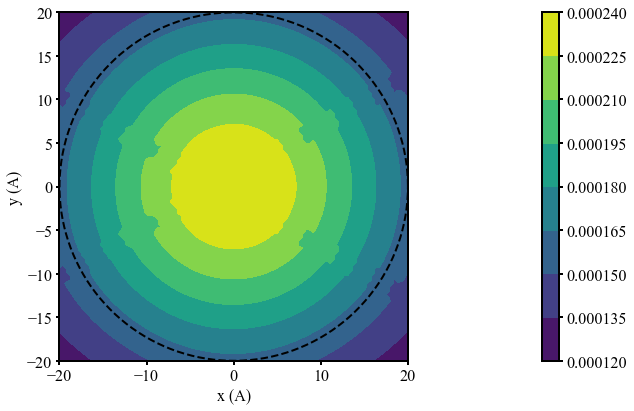

In [319]:
theta_list = np.linspace( 0 , 2 * np.pi , 150 )
 
radius = 1e10*a_s
 
a = radius * np.cos(theta_list)
b = radius * np.sin(theta_list)

size = 100
xc, yc = np.linspace(-radius, radius,100), np.linspace(-radius, radius,100)
X, Y = np.meshgrid(xc, yc)

Z = np.zeros(np.shape(X.flatten()))

for i in range(len(Z)):
    wrap_pt = wrap_pos([X.flatten()[i], Y.flatten()[i]], bvec1, bvec2, orig=orig)[1]
    Z[i] = ip_red(wrap_pt[0], wrap_pt[1])
        
Z = Z.reshape((size, size))
f = interp2d(xc, yc, Z, kind='cubic')

plt.contourf(X, Y, f(xc, yc))
plt.plot(a, b, 'k--')
plt.colorbar()
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.axis('square')
#plt.xlim([-radius/10, radius/10])
#plt.ylim([-radius/10, radius/10])
plt.xlabel('x (A)')
plt.ylabel('y (A)')
plt.tight_layout()
#plt.savefig('mesh_20_kred.png')

In [295]:
f(-30, 0)

array([0.00011189])

In [299]:
f(0, 0)

array([0.00023745])

In [224]:
P1 = FiniteElement('P', tetrahedron, 1)
vec = project(kred_f, FunctionSpace(mesh, P1))
save_sol('kred_f', vec, mesh)

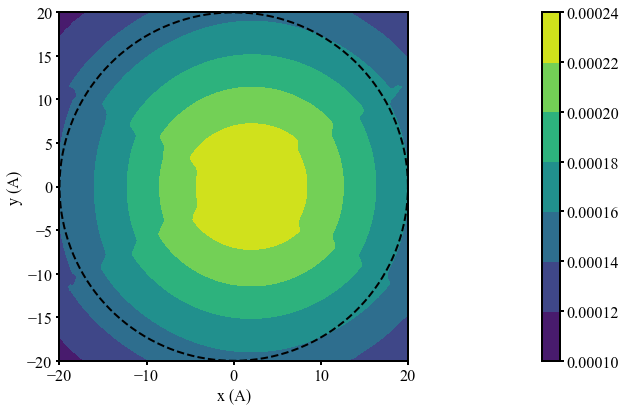

In [317]:
#
P1 = FiniteElement('P', tetrahedron, 1)
#vec = interpolate(kred_f, FunctionSpace(mesh, P1))
vec = project(kred_f, FunctionSpace(mesh, P1))
#vec = interpolate(project(kred_f, FunctionSpace(mesh, P1)), FunctionSpace(mesh, P1))#V_k.sub(1))#FunctionSpace(mesh, P1))
vec.set_allow_extrapolation(True)
#File("kred_f.pvd").write(vec)

Z2 = np.zeros(np.shape(X.flatten()))
ip_red(X, Y)
for i in range(len(Z2)):
    #wrap_pt = wrap_pos([X.flatten()[i], Y.flatten()[i]], bvec1, bvec2, orig=orig)[1]
    #p = 1e-10*np.array([wrap_pt[0], wrap_pt[1], 0.0])
    p = 1e-10*np.array([X.flatten()[i], Y.flatten()[i], 0.0])
    #print(p)
    Z2[i] = vec(*Point(p)) #ip_red(wrap_pt[0], wrap_pt[1])[1]
        
Z2 = Z2.reshape((size, size))
plt.contourf(X, Y, Z2)
plt.plot(a, b, 'k--')
plt.colorbar()
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.axis('square')
#plt.xlim([-radius, radius])
#plt.ylim([-radius, radius])
plt.xlabel('x (A)')
plt.ylabel('y (A)')
plt.tight_layout()

In [297]:
vec(*Point(np.array([-30e-9,0,0])))

0.0001527870163429831

In [298]:
vec(*Point(np.array([0,0,0])))

0.00023626115249159052

In [228]:
kred_f = Function(FunctionSpace(mesh, P1))
load_sol('kred_f.h5', kred_f, mesh)

Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', tetrahedron, 1), dim=3), 738), FiniteElement('Lagrange', tetrahedron, 1)), 1093)

In [229]:
kred_f

Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', tetrahedron, 1), dim=3), 738), FiniteElement('Lagrange', tetrahedron, 1)), 1093)

In [ ]:
P1 = FiniteElement('P', tetrahedron, 1)
#vec = 
#File("kred_f.pvd").write(vec)
project(Vdl_f, FunctionSpace(mesh, P1))

# PNP Solve

In [46]:
# Solve

deg = 1
phi_D = Expression(str(0.0), degree=deg)

def boundary(x, on_boundary):
    return on_boundary

# phi = TrialFunction(V_phi)
# v = TestFunction(V_phi)

## initialize conc                                                                                                                      
P1 = FiniteElement('P', tetrahedron, 1)
element = MixedElement([P1, P1, P1, P1, P1])
V = FunctionSpace(mesh, element)

c_a = Expression(str(c_KCl), degree=deg)
c_b = Expression(str(z_1*c_KCl + z_3*c_ruhex), degree=deg)
c_c = Expression(str(c_ruhex), degree=deg)
c_d = Expression(str(0.0), degree=deg)

v, q_1, q_2, q_3, q_4 = TestFunctions(V)
sol = Function(V)
dsol = TrialFunction(V)
phi, c_1, c_2, c_3, c_4 = split(sol)
#c_ini = load_sol('Sol/_c',c,mesh)
#c.vector()[:] = c_ini.vector()[:]
#sol.vector().set_local(rand(sol.vector().size())) # For starting calculations
#sol.vector().apply("")

## BCs
tol = DOLFIN_EPS
def boundary_5(x, on_boundary):
    return on_boundary and near(x[2], z_t, tol)

# phi BCs                                                                                                                               
bc_1= DirichletBC(V.sub(0), phi_D, boundary_5)                                                                                                                      

# conc BCs                                                                                                                              
bc_5a= DirichletBC(V.sub(1), c_a, boundary_5)
bc_5b= DirichletBC(V.sub(2), c_b, boundary_5)
bc_5c= DirichletBC(V.sub(3), c_c, boundary_5)
bc_5d= DirichletBC(V.sub(4), c_d, boundary_5)
bcs = [bc_1, bc_5a, bc_5b, bc_5c, bc_5d]

## Different Neumann BC for bottom BC                                                                                                   
## create a mesh function which assigns an unsigned integer (size_t) to each edge                                                        
mf = MeshFunction("size_t", mesh, mesh.topology().dim() - 1) # 3rd argument is dimension of an edge                                                             
mf.set_all(0) # initialize the function to zero                                                                                         
class BottomBoundary(SubDomain):
    def inside(self, x, on_boundary):
        tol = DOLFIN_EPS
        return near(x[2], 0.0, tol) and on_boundary # Use x[2] for 3D.

bottomboundary = BottomBoundary() # instantiate it 

# use this bottomboundary object to set values of the mesh function to 1 in the subdomain                                               
bottomboundary.mark(mf, 1)

## Define a new measure ds based on this mesh function                                                                                   
ds = Measure("ds", domain=mesh, subdomain_data=mf)
#File("mf.pvd").write(mf) # Save mf for Paraview                                                                                        

### Compute solution                                                                                                                    
## Define problem for phi                                                                                                               
n = FacetNormal(mesh)
#r = Expression('x[0]', degree=deg)
#nabla_phi = (z_1*c_1 + z_2*c_2 + z_3*c_3 + z_4*c_4)                                                                                    
dphi_1 = Expression('0.0', degree=deg)

## Define problem for conc                                                                                                                                                                                                                 
g_1 = Expression('0.0', degree=deg)
g_2 = Expression('0.0', degree=deg)
g_3 = Expression('0.0', degree=deg)
g_4 = Expression('0.0', degree=deg)
#m1 = dot(grad(c_3), n)                                                                                                                 
#m1 = Dx(c_3,1) does not give correct solution  
#kox, kred = BV_rates(k_o, eta=Vapp)
#m1 = -(kred*c_3 - kox*c_4)/D_o # Rate theory input 
# m2 = dot(grad(c_4), n)

## Input kinetic rates
rscx = ldos_data["rscx"]
rscy = ldos_data["rscy"]
kred_data, kox_data = rate_data["kred_data"], rate_data["kox_data"]
Vdl_data = rate_data["Vdl_data"]
theta = np.squeeze(ldos_data["theta"])
nsamps = ldos_data["nsamps"]
Vapp = rate_data["Vapp"]
print('Vapp={}'.format(Vapp),'\n')

moir_l, sc_area = tblg_dim(theta) # Moire supercell length and area Ang
moir_a = np.pi/3 # Moire angle 60deg
orig = moir_l*np.array([rscx[0,0], rscy[0,0]]) # Origin of the moire supercell, custom set for other centers
bvec1 = np.array([moir_l*np.cos(moir_a/2), moir_l*np.sin(moir_a/2)]) # basis vector 1
bvec2 = np.array([moir_l*np.cos(moir_a/2), -moir_l*np.sin(moir_a/2)]) # basis vector 2
coords = moir_l*np.array([rscx.flatten(), rscy.flatten()]) # In Ang, convert accordingly
z_red, z_ox = kred_data.flatten(), kox_data.flatten()
ip_red, ip_ox = my_CT(coords, z_red), my_CT(coords, z_ox) # 2D interpolators of kred and kox
ip_Vdl = my_CT(coords, Vdl_data.flatten()) # Interpolators take coords in Angstroms

V_k = FunctionSpace(mesh, MixedElement([P1, P1, P1]))
k_model = Function(V_k)
u_bc = Model_rates(ip_red, ip_ox, ip_Vdl, bvec1, bvec2, orig)
k_model = interpolate(u_bc, V_k)
kred_f, kox_f, Vdl_f = k_model[0], k_model[1], k_model[2]
File("kred_f.pvd").write(kred_f)
# V_k = FunctionSpace(mesh, MixedElement([P1, P1, P1]))
# k_model = Function(V_k)
# u_bc = Model_rates_test(Vapp, a_s)
# k_model = interpolate(u_bc, V_k)
# kred_f, kox_f, Vdl_f = k_model[0], k_model[1], k_model[2]

## Solve 3D-PNP
Func = (inner(grad(phi),grad(v)))*dx() - ((Vdl_f - phi)/d_h)*v*ds(1) \
    - (F/(eps*eps0))*(z_1*c_1 + z_2*c_2 + z_3*c_3 + z_4*c_4)*v*dx() + dphi_1*v*ds(0) \
    + ((inner(grad(c_1), grad(q_1))) - ((z_1/kbT)*div(c_1*grad(phi))*q_1))*dx() \
    + ((inner(grad(c_2), grad(q_2))) - ((z_2/kbT)*div(c_2*grad(phi))*q_2))*dx() \
    + ((inner(grad(c_3), grad(q_3))) - ((z_3/kbT)*div(c_3*grad(phi))*q_3))*dx() \
    + ((inner(grad(c_4), grad(q_4))) - ((z_4/kbT)*div(c_4*grad(phi))*q_4))*dx() \
    - g_1*q_1*ds() - g_2*q_2*ds() - g_3*q_3*ds(0) - g_4*q_4*ds(0) \
    - (-(kred_f*c_3 - kox_f*c_4)/D_o)*q_3*ds(1) \
    + (-(kred_f*c_3 - kox_f*c_4)/D_r)*q_4*ds(1) \
    #- m1*q_3*ds(1) + (D_o/D_r)*m1*q_4*ds(1) \

#a = lhs(Func)
#L = rhs(Func)
L = 0

#c.vector()[:] = csol.vector()[:]
#c.vector().set_local(rand(c.vector().size())) # For starting calculations
#c.vector().apply("")

# Solver configs                                                                                                                        
ffc_options = {"optimize": True, "quadrature_degree": 6}

solver_parameters = {"nonlinear_solver": "snes",
                     "snes_solver" : {
                         "report" : True,
                         "error_on_nonconvergence" : False,
                         "line_search" : "bt",
                         "linear_solver" : "bicgstab", # cg, bicgstab, gmres, lu, superlu_dist                                          
                         "preconditioner" : "sor", # sor, amg, hypre_euclid, petsc_amg, ilu, icc                                                                   
                         "absolute_tolerance" : 1E-7,
                         "relative_tolerance" : 1E-6,                                                                                  
                         "maximum_iterations" : 20000,                                                                                 
                         "krylov_solver" : {
                             "maximum_iterations" : 40000,
                             #"monitor_convergence" : True,                                                                             
                             "nonzero_initial_guess" : False
                         }}}

J = derivative(Func, sol, dsol)
problem = NonlinearVariationalProblem(Func, sol, bcs, J, form_compiler_parameters=ffc_options)
solver = NonlinearVariationalSolver(problem)
solver.parameters.update(solver_parameters)
solver.solve()

# solve(Func == L, sol, bcs, solver_parameters=solver_parameters)
_phi, _c_1, _c_2, _c_3, _c_4 = sol.split()

Vapp=0.0 



KeyboardInterrupt: 

In [149]:
# fig = go.Figure(data =
#     go.Contour(
#         z=[[10, 10.625, 12.5, 15.625, 20],
#            [5.625, 6.25, 8.125, 11.25, 15.625],
#            [2.5, 3.125, 5., 8.125, 12.5],
#            [0.625, 1.25, 3.125, 6.25, 10.625],
#            [0, 0.625, 2.5, 5.625, 10]]
#     ))
# fig.show()

## Check Solution

In [232]:
point = [0.5e-7, 0.5e-7, 0]
x = np.array(point)
x_point = Point(*x) 
P1 = FiniteElement('P', tetrahedron, 1)
vec = project(_c_3.dx(2), FunctionSpace(mesh, P1))
vec(x_point)

1737.8843466404116

In [235]:
point = [0.5e-7,-0.8e-7, 0]
x = np.array(point)
x_point = Point(*x) 
P1 = FiniteElement('P', tetrahedron, 1)
vec = project(_phi.dx(2), FunctionSpace(mesh, P1))
vec(x_point)

-138876.83068299355

In [214]:
#(V_dl - _phi(0.0e-7, 0.0e-7, 0))/d_h

In [237]:
#0.0 -7.252246359889353e-13
#-0.1 -3.4315832463556725e-12
#-0.2 -6.17697087431695e-12
#0.2 -4.2238448855497015e-15
curr = get_current_3D(_c_3, mesh, D_o, a_s)
curr

-4.2238448855497015e-15

In [236]:
#point = [0.0e-7, 0.0e-7, 0]
x = np.array(point)
x_point = Point(*x)
P1 = FiniteElement('P', tetrahedron, 1)
vec = project(Vdl_f, FunctionSpace(mesh, P1))
(vec(x_point) - _phi(point))/d_h

50775.45518014648

In [168]:
ip_red, ip_ox = interpolator_2d(coords[0,:], coords[1,:], z_red), interpolator_2d(coords[0,:], coords[1,:], z_ox) # 2D interpolators of kred and kox
ip_Vdl = interpolator_2d(coords[0,:], coords[1,:], Vdl_data.flatten())
ip_Vdl(121.28331801, -0.38194015)

array(nan)

In [151]:
bvec2, orig
coords
max(coords[0,:])

118.48108147912794

In [147]:
2*np.cos(np.pi/6)*moir_l

122.56663601289098

In [155]:
pt = [122,0] # [61,35]
wrap_pt=wrap_pos(pt, bvec1, bvec2, orig=orig)[1]
wrap_pt

array([ 1.22000000e+02, -2.03499459e-15])

In [163]:
ip_Vdl(wrap_pt)
ip_Vdl([118.4,0])
ip_Vdl([0,0])

array([-0.03815387])

# Analysis and pp

In [85]:
p_list = np.linspace(0, a_s*0.8, 15)
ang = 35 # deg
P1 = FiniteElement('P', tetrahedron, 1)
vec1 = project(_phi.dx(2), FunctionSpace(mesh, P1))
vec2 = project(Vdl_f, FunctionSpace(mesh, P1))
vec1.set_allow_extrapolation(True)
vec2.set_allow_extrapolation(True)
Vdiff, d2phi = [], []
for p in p_list:
    point = [p*np.cos(np.deg2rad(ang)), p*np.sin(np.deg2rad(ang)), 0.0]
    x = np.array(point)
    x_point = Point(*x) 
    Vdiff.append((vec2(x_point) - _phi(point))/d_h)
    d2phi.append(vec1(x_point))

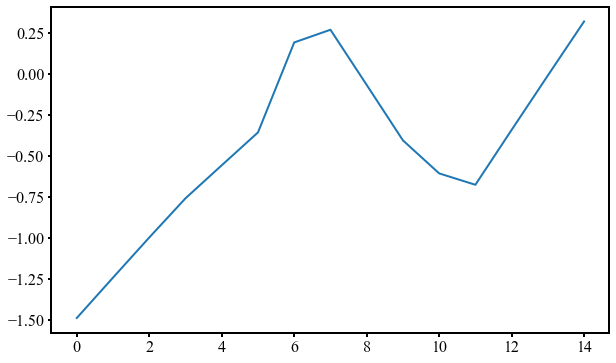

In [86]:
#print(Vdiff)
#print(d2phi)
plt.plot(100*(np.array(Vdiff)+np.array(d2phi))/np.array(Vdiff))

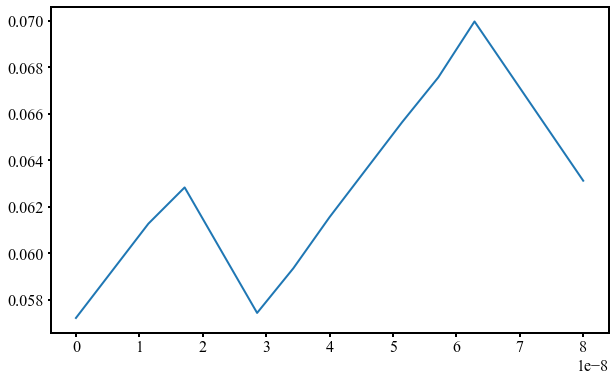

In [238]:
p_list = np.linspace(0, a_s*0.8, 15)
ang = 35 # deg
vdl_list = []
vec2 = project(Vdl_f, FunctionSpace(mesh, P1))
vec2.set_allow_extrapolation(True)
for p in p_list:
    vdl_list.append(vec2(Point(*np.array([p*np.cos(np.deg2rad(ang)), p*np.sin(np.deg2rad(ang)), 0.0]))))
    
plt.plot(p_list, vdl_list)

5.000000000000002e-09 3.500000000000001e-06 2e-05
Building point search tree to accelerate distance queries.
Computed bounding box tree with 435519 nodes for 217760 points.


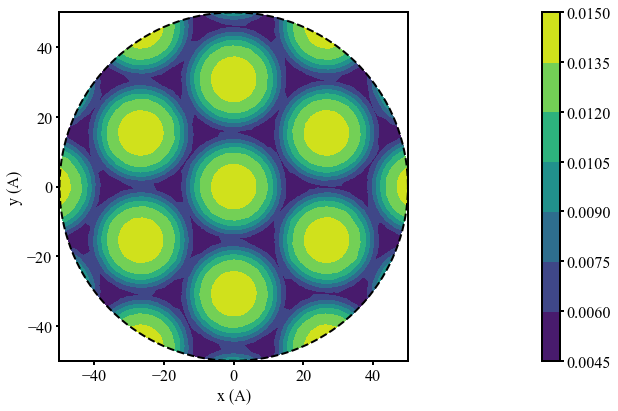

In [81]:
mesh = Mesh('/Users/mbabar/Desktop/PhD/Analysis/PDE/PNP_solve/3D_vmg/Mesh/Testing/mesh_5.xml')

# Scale mesh
m_coords = mesh.coordinates()
scal_r = np.float64(1e-9)
m_coords[:, :] *= scal_r
mesh.bounding_box_tree().build(mesh) # development version
#mesh_file = File("mesh_scale.xml")
#mesh_file << mesh

a_s, a_t, z_t = get_mesh_geo(mesh) # Mesh geometry
print(a_s, a_t, z_t)

fname = '/Users/mbabar/Desktop/PhD/Analysis/PDE/PNP_solve/3D_vmg/ldos_incorp/Single_run/5nm/4.6deg_shift_0/kox_f'
P1 = FiniteElement('P', tetrahedron, 1)
vec = Function(FunctionSpace(mesh, P1))
load_sol(fname+'.h5', vec, mesh)
vec.set_allow_extrapolation(True)


theta_list = np.linspace( 0 , 2 * np.pi , 150 )
radius = 1e10*a_s 
a = radius * np.cos(theta_list)
b = radius * np.sin(theta_list)

size = 500
xc, yc = np.linspace(-radius, radius,size), np.linspace(-radius, radius,size)
X, Y = np.meshgrid(xc, yc)

Z2 = np.zeros(np.shape(X.flatten()))

for i in range(len(Z2)):
    p = 1e-10*np.array([X.flatten()[i], Y.flatten()[i], 0.0])
    #print(p)
    if norm(p) > a_s:
        Z2[i] = np.nan
    else:
        Z2[i] = vec(*Point(p)) #ip_red(wrap_pt[0], wrap_pt[1])[1]
    #print(p)

        
Z2 = Z2.reshape((size, size))
plt.contourf(X, Y, Z2)
plt.plot(a, b, 'k--')
plt.colorbar()
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.axis('square')
#plt.xlim([-radius, radius])
#plt.ylim([-radius, radius])
plt.xlabel('x (A)')
plt.ylabel('y (A)')
plt.tight_layout()

# Save data
contour_data = {'X':X, 'Y':Y, 'Z':Z2, 'a_s':a_s}
savemat('contour_data.mat', contour_data)

In [40]:
vec(*Point(np.array([3e-9, 0., 0.])))

0.005627347500332522

In [44]:
np.nanmax(Z2)/np.nanmin(Z2)

16.901471160944695

In [ ]:
0.00591246957412934, 0.00591246957412934
0.09462958444216805, 0.009573330899811598

In [27]:
(5734.535568119713/A_ab)*0.009573330899811598

0.09470013463091438

In [25]:
A_ab = 579.7099102795545

5.000000000000002e-09 3.500000000000001e-06 2e-05
Building point search tree to accelerate distance queries.
Computed bounding box tree with 435519 nodes for 217760 points.


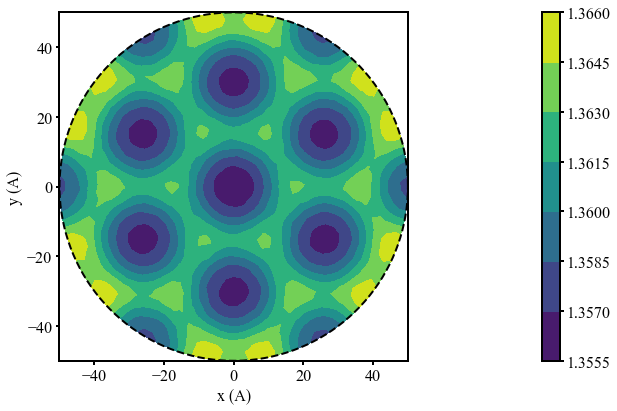

In [82]:
mesh = Mesh('/Users/mbabar/Desktop/PhD/Analysis/PDE/PNP_solve/3D_vmg/Mesh/Testing/mesh_5.xml')

# Scale mesh
m_coords = mesh.coordinates()
scal_r = np.float64(1e-9)
m_coords[:, :] *= scal_r
mesh.bounding_box_tree().build(mesh) # development version
#mesh_file = File("mesh_scale.xml")
#mesh_file << mesh

a_s, a_t, z_t = get_mesh_geo(mesh) # Mesh geometry
print(a_s, a_t, z_t)

fname = '/Users/mbabar/Desktop/PhD/Analysis/PDE/PNP_solve/3D_vmg/ldos_incorp/Single_run/5nm/4.6deg_shift_0/config_0'
P1 = FiniteElement('P', tetrahedron, 1)
element = MixedElement([P1, P1, P1, P1, P1])
V = FunctionSpace(mesh, element)
sol = Function(V)
load_sol(fname+'.h5', sol, mesh)
_phi, _c_1, _c_2, _c_3, _c_4 = split(sol)
vec = Function(FunctionSpace(mesh, P1))
vec = project(_c_3, FunctionSpace(mesh, P1)) #_c_3.dx(2)
vec.set_allow_extrapolation(True)

theta_list = np.linspace( 0 , 2 * np.pi , 150 )
radius = 1e10*a_s 
a = radius * np.cos(theta_list)
b = radius * np.sin(theta_list)

size = 500
xc, yc = np.linspace(-radius, radius,size), np.linspace(-radius, radius,size)
X, Y = np.meshgrid(xc, yc)

Z2 = np.zeros(np.shape(X.flatten()))

for i in range(len(Z2)):
    p = 1e-10*np.array([X.flatten()[i], Y.flatten()[i], 0.0])
    if norm(p) > a_s:
        Z2[i] = np.nan
    else:
        Z2[i] = vec(*Point(p)) #ip_red(wrap_pt[0], wrap_pt[1])[1]
        
Z2 = Z2.reshape((size, size))
plt.contourf(X, Y, Z2)
plt.plot(a, b, 'k--')
plt.colorbar()
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.axis('square')
#plt.xlim([-radius, radius])
#plt.ylim([-radius, radius])
plt.xlabel('x (A)')
plt.ylabel('y (A)')
plt.tight_layout()

# Save data
contour_data = {'X':X, 'Y':Y, 'Z':Z2}
savemat('contour_data.mat', contour_data)

In [342]:
vec(*Point(np.array([1e-9,0,0])))

99.61557573897619

In [327]:
a_s

2.000000000000001e-09

In [329]:
p

array([2.e-09, 2.e-09, 0.e+00])

In [330]:
norm(p) > a_s

True